# Stop and Frisk
Brad Johnson and Steven Dye

## Problem Statement
Can we predict who will be arrested based on information obtained before the stop is initiated?

We attempt to model what are effective stops, i.e.,  which ones lead to arrests and  non-arrests. With the issues that surround Stop-and-frick, i.e., unreasonable search and seizure being unconstitutional, having a racial bias in profiling is illegal, and police activity without any effectiveness on crime is wasted resourse, we hope to make a model that can improve the conversion rate of stops.

## Data

The data for this project was collect from a wide variety of sources, ranging from years 2003-2018. Most of it comes from the NYPD Complaint Data Historic website. This dataset includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of last year (2017). The sum of the data consists of 119 columns and 5,051,677 entires, resulting in over 1.9 GB of data. For computational sake, every step in this process only looked at 0.1% of the full data. Note: Loading the pickle data folder may take several minutes.

In [12]:
import data_cleaner as dc
import data_modeler as dm
import importlib

df = dc.load_full_sqf()
df_sample = df.sample(frac=.001)

## Data Preprocessing

The data is cleaned using the data_cleaner.py file. This consists of realligning columns so they are consistent through each year, correcting spelling mistakes, and changing entires so they are consistent as well.

The data was broken up into subsets based on its data type, categorical and yes/no questions. Categorical data was one hot encoded and then recobined with yes/no data.

## Early Data Assessment

While there were some features that were very good predictors of an arrest occuring (use of handcuffs or weapon being found on the suspect), we decided to use only features that could be determined before the stop was initiated (day of the week, sex, location). This decision was made because we want to imporve the conversion rate of stops turning into arrests, so information obtained during the stop does not improve the conversion rate. From here we plotted the counts of arrest for each categorical feature still being considered.

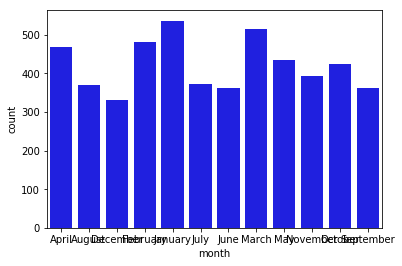

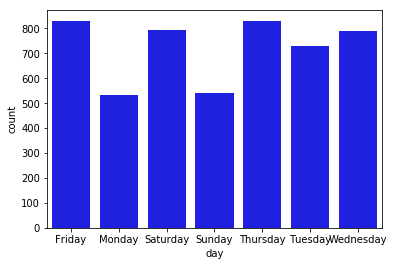

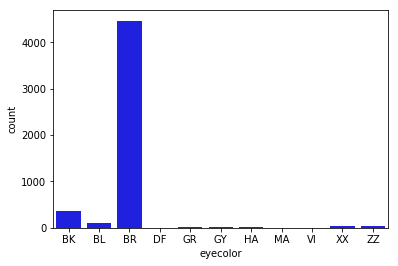

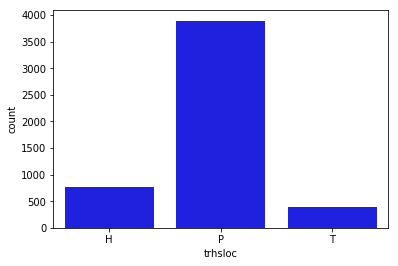

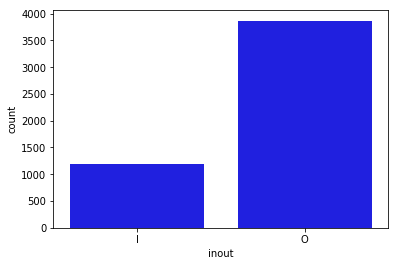

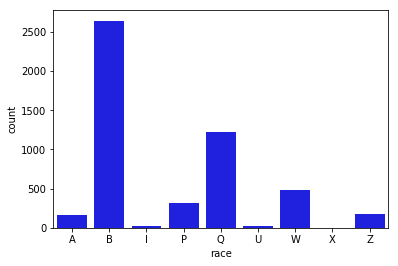

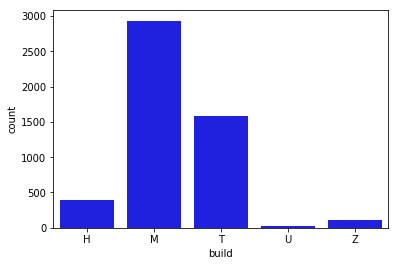

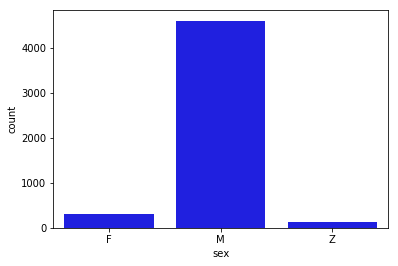

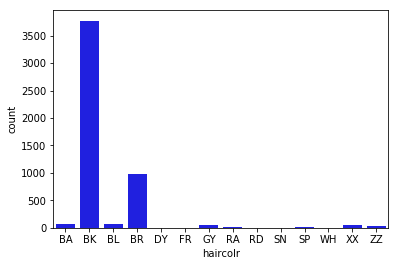

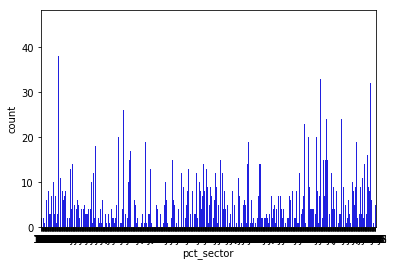

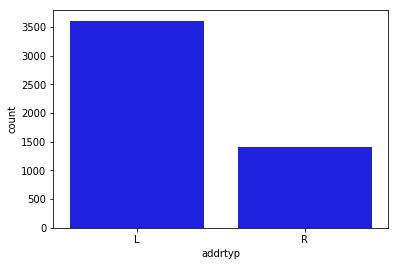

In [13]:
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import seaborn as sns
X_pre_so = df_sample[dm.PRE_STOP_OBSERVABLES]
y = df_sample.arstmade

# Brake up the data into categorical features and Y/N features
X_category = X_pre_so.select_dtypes(include='category')
X_yn = X_pre_so.select_dtypes(include='int8')

# Fill in missing values in X_category and one hot encode categorical features.
X_cat_nonan = dm.fill_NaNs(X_category) # fills in NaNs
X_ohe, ohe_feat_names = dm.categorical_encoder(X_cat_nonan)
X_ohe_df = pd.DataFrame(X_ohe.toarray())
X_ohe_df.columns = ohe_feat_names

# Merge X_ohe and X_yn
X_merged = np.concatenate((X_ohe_df, X_yn), axis = -1)
all_names = ohe_feat_names.tolist() + X_yn.columns.tolist()

for i, col in enumerate(X_category.columns):
    plt.figure(i)
    sns.countplot(x=col, data=X_category, color="b")

## Modeling

The code for the modeling section can be found in the data_modeler.py file. While initially we looked at both a logistic regressiona and a random forest model, we decided to only use a random forest model in the end due to its ability to select features and due to computational limitations. The data was split using train_test and SMOTE was used to balance the data in the training set.

In [20]:
merged_split = dm.load_split(X_merged, y, stratify=y)
merged_rf = dm.run_rf(merged_split, max_depth=2, n_estimators=10)

From here we can see what features are were most important for our model.

In [33]:
rf_feature_df = pd.DataFrame([merged_rf.feature_importances_], columns=all_names)
rf_feature_df.T.sort_values(0)

,0
x9_34-,0.000000
x9_5-E,0.000000
x9_5-F,0.000000
x9_5-G,0.000000
x9_50-,0.000000
...,...
cs_other,0.070622
x1_Sunday,0.074524
x0_May,0.078141
cs_casng,0.091660


A balcanced accuracy score was used to evaluate our model. This was chosen over a traditional accuracy score due to the imbalnce in our data, only about 5% of the people who were stopped were arrested.

In [16]:
from sklearn.metrics import balanced_accuracy_score

predictions = merged_rf.predict(merged_split['X_train'])
print(balanced_accuracy_score(merged_split['y_train'], predictions))

predictions = merged_rf.predict(merged_split['X_test'])
print(balanced_accuracy_score(merged_split['y_test'], predictions))

0.5955555555555556
0.567929292929293


Note: A dummy model that only predicts one option or another (in this case only choosing arrested or not arrested) can only achieve a maximum balanced score of 0.5.

## Future Work

In order to improve this project, the following are steps that we want to implement:

* Populate missing city fields from precinct info
* Fill in missing values for sector
* Gridsearch to search for best hyperparameters